# Maximum Likelihood (part 02)
```
Shivam Kumaran
sc17b122
date 17/11/2020
Computational Astrophysics
```

### Importing required Modules

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import matplotlib.gridspec as gs
import seaborn as sns
plt.rcdefaults()
sns.set_theme(font_scale=1.1)
plt.style.use('seaborn-dark-palette')


## Histogram functions

In [2]:
import numpy as np 
def pdf_const_bin(x, bins):
    '''
    generate Probability distribution function corresponding 
    to given samples of random variables x 
    against bins 
    '''
    x = np.asarray(x)
    v_min = np.amin(x)
    v_max = np.amax(x)
    h = (v_max-v_min)/bins
    tot_length = len(x)
    #print(v_min , v_max)
    hist = []
    x_axis = []
    for i in range(bins):
        temp_min = v_min+i*h
        temp_max = v_min+(i+1)*h
        #print(temp_min, temp_max)
        temp = [x_val for x_val in x if ((x_val>temp_min) and(x_val<=temp_max))]
        #print(temp)
        count = (len(temp)/tot_length)/h
        hist.append(count)
        x_axis.append((temp_min+temp_max)/2)
    return(hist , x_axis)


def histogram(x,bins):

    def histogram_const_bin(x, bins):
        x = np.asarray(x)
        v_min = np.amin(x)
        v_max = np.amax(x)
        h = (v_max-v_min)/bins
            #print(v_min , v_max)
        hist = []
        x_axis = []
        for i in range(bins):
            temp_min = v_min+i*h
            temp_max = v_min+(i+1)*h
                #print(temp_min, temp_max)
            temp = [x_val for x_val in x if ((x_val>temp_min) and (x_val<=temp_max))] 
                #print(temp)
            count = len(temp)
            hist.append(count)
            x_axis.append((temp_min+temp_max)/2)
        return(hist , x_axis)

    def histogram_given_bin(x, bins):
        x = np.asarray(x)
        v_min = np.amin(x)
        v_max = np.amax(x)
        h = (v_max-v_min)/bins
            #print(v_min , v_max)
        hist = []
        x_axis = []
        for i in range(len(bins)):
            temp = [x_val for x_val in x if ((x_val>bins[i]) and (x_val<=bins[i+1]))] 
                #print(temp)
            count = len(temp)
            hist.append(count)
                #x_axis.append((temp_min+temp_max)/2)
        return(hist, bins)


    if(type(bins)==int):
        hist , bins = histogram_const_bin(x,bins)
    else:
        hist , bins = histogram_given_bin(x,bins)
    return(hist, bins)



### Generating samples and Likelihood calculation

In [3]:
def gen_rand_n(x_min ,x_max , n):
    import random as rnd 
    x = []
    n = int(n)
    for i in range(n):
        mu = rnd.uniform(0,1)
        xi = x_min + mu*(x_max-x_min)
        x.append(xi)
    if (len(x)==1):
        return x[0]
    else:
        return x

def gen_samples(f,x_min , x_max , y_max , N):
    import numpy as np 
    x_acc = []
    i = 0
    while(i<N):
        x = gen_rand_n(x_min,x_max,1)
        y = np.random.uniform(0,y_max)
        if(y<=f(x)):
            x_acc.append(x)
            i+=1
    return x_acc

def calc_likelihood(pdf , data , log_lik = True , neg = False):
    log_l = 0
    if(log_lik):
        log_l = sum([np.log(pdf(d)) for d in data])
        if(neg):
            return log_l
        else :
            return (-log_l)


## Given PDF

After Normalisation :

$p(cos\theta) = N\times (1+\alpha* cos^2(\theta))$

$N  = 1/(2*(1+\frac{\alpha}{3}))$ 

In [4]:
def scatter_dist(alpha):
    def to_return(x):
        N = 2*(1+alpha/3)
        val = (1+alpha*(x**2))/N
        return val
    return to_return

### Quick look at the data

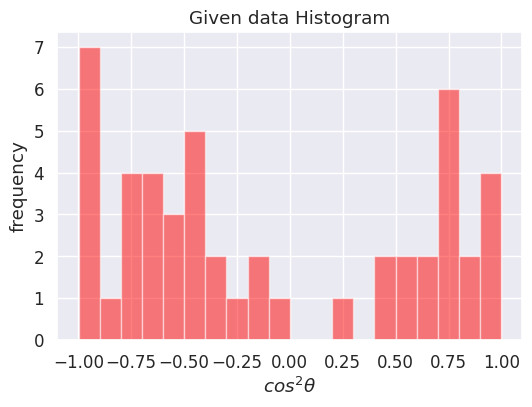

In [5]:
data =  np.loadtxt('list' , delimiter=',')
dist_obs , bins_obs = histogram(data , int(20)) 

fig  = plt.figure(figsize=(6,4))
spec = gs.GridSpec(ncols=1 , nrows=1)
ax1 = fig.add_subplot(spec[0,0])
ax1.bar(bins_obs, dist_obs ,  width=0.1 , color='red' , alpha = 0.5 )
#ax1.plot(x ,y_th , color='k')
#ax1.legend(['true PDF' , 'simulated data N: 500'])
ax1.set_xlabel(r'$cos^2\theta$')
ax1.set_ylabel(r'frequency')
plt.title('Given data Histogram')
plt.show()

### Log likelihood
$-log(L) / (log(-L_{min}))$

$ L = \Pi _i ( N\times (1+\alpha \times cos^2(\theta)))$

$N = 1/(2*(1+\frac{\alpha}{3}))$ 

$Log(L) =  \sum_i ( N\times (1+\alpha \times cos^2(\theta)))$

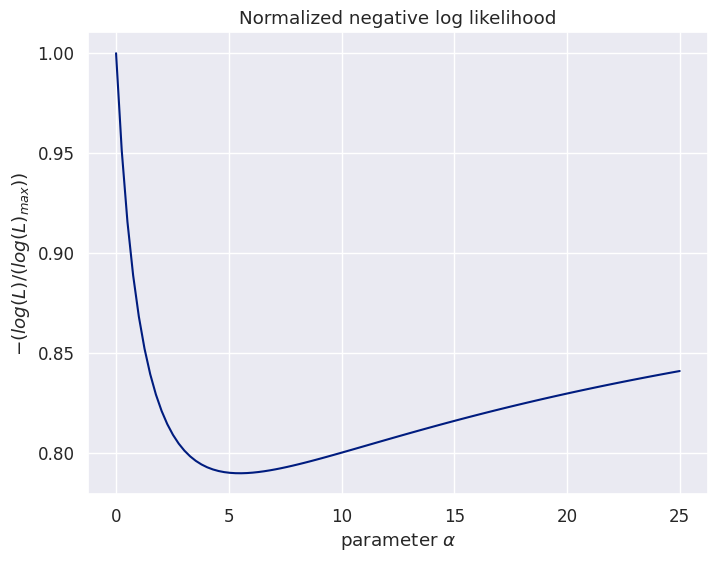

In [6]:
alpha = np.linspace(0 , 25 , 100)
neg_log_lh = []
for a in alpha:
    neg_log_lh.append(calc_likelihood(scatter_dist(a) , data , neg=True))

plt.figure(figsize=(8,6))
plt.plot(alpha , neg_log_lh / np.amin(neg_log_lh))
plt.title('Normalized negative log likelihood')
plt.xlabel(r'parameter $\alpha$')
plt.ylabel(r'$-(log(L)/(log(L)_{max}))$')
plt.show()

### Minimizing Negative Log-likelihood
Minimizing negative of log-likelihood is same as maximizing log likelihood

> Method used :
parameter update is scaled by the gradient at the given point and in the direction opposite to gradient at the given point  , hence step size is adaptive to the gradient and can reach maxima faster without overshooting it

$p_{next} = p_{prev}-\nabla_p(-log(L)) \times \Delta p$ 


In [7]:
def find_extrema(pdf , d , p_min , p_max):
    p = p_min
    del_p = 0.1
    prev = calc_likelihood(scatter_dist(p) , d)
    nxt = calc_likelihood(scatter_dist(p+del_p) , d)
    grad = (nxt-prev)/del_p
    
    while(abs(grad)>1e-4):
        prev = calc_likelihood(scatter_dist(p) , d)
        nxt = calc_likelihood(scatter_dist(p+del_p) , d)
        #grd_prev = grad
        grad = (nxt-prev)/del_p
        del_p = 0.1
        p = p-(grad)*del_p
        #print(p)
    return p 
alpha_est = (find_extrema(scatter_dist ,data , 0 , 20))
print('Estimated alpha value :{:.4f}'.format(alpha_est))

Estimated alpha value :5.4332


> Estimated Parameter Value : 5.43322

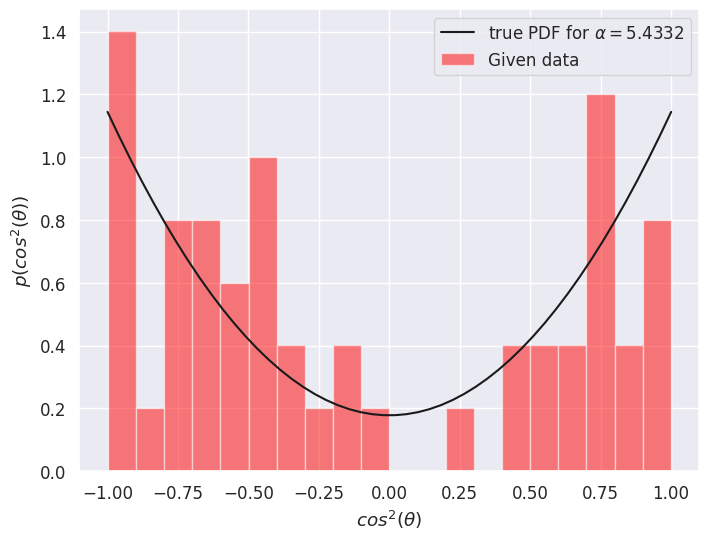

In [8]:
dist_obs , bins_obs = pdf_const_bin(data , 20)
width_obs = bins_obs[1]-bins_obs[0]

x = np.linspace(-1 , 1 )
y_th = scatter_dist(alpha_est)(x)

fig  = plt.figure(figsize=(8,6))
spec = gs.GridSpec(ncols=1 , nrows=1)
ax1 = fig.add_subplot(spec[0,0])
ax1.bar(bins_obs, dist_obs ,  width=0.1 , color='red' , alpha = 0.5 )
ax1.plot(x ,y_th , color='k')
ax1.legend([r'true PDF for $\alpha = ${:.4f}'.format(alpha_est) , 'Given data'])
ax1.set_xlabel(r'$cos^2(\theta)$')
ax1.set_ylabel(r'$p(cos^2(\theta))$')
plt.show()

In the figure above , Histogram for the given data is converted to PDF

$p(x) = \frac{n_{x}}{N} \times \frac{1}{\Delta x}$

$n_x$ : number of data points in the given bin

## Conclusion 
> Estimated Parameter Value : 5.43322